# Results of this project

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical

from tqdm import tqdm
import sys
sys.path.append("../scripts")

from functions import predict_file

from sklearn.metrics import confusion_matrix, accuracy_score, balanced_accuracy_score

## Config

In [2]:
import json

config = json.load(open("../resources/config.json", "r"))

class cfg:
    # random seed
    seed = 42

    # audio clip settings
    sr = config["sampling_rate"] # 22050
    duration = config["duration"] # 15 # the duration of the clips
    
    n_samples = duration*sr
    
    hop_length = config["hop_length"] # 2048 # "stepsize" of the fft for the melspectrograms
    nfft = config["nfft"] # 4096 # windowsize of the fft for the melspectrograms
    n_mels = config["n_mels"] # 128 # number of mel frequency bins
    fmax = sr/2 # maximum frequency in the melspectrograms
    input_dim = (n_mels, int(duration*sr//hop_length + 1))
    
    # training settings
    batch_size = config["batch_size"] # 32
    n_epochs = config["n_epochs"]

    n_classes = 46

### Load dataframes

In [3]:
df_train = pd.read_csv("../../data/dataset_train.csv")
df_test = pd.read_csv("../../data/dataset_test.csv")

df_train.fullfilename = "../" + df_train.fullfilename
df_test.fullfilename = "../" + df_test.fullfilename

### Load trained models and log files

In [4]:
models = []
logs = []
for i in range(5):
    models.append(load_model(f"../models/final_model_{i+1}.keras"))
    logs.append(pd.read_csv(f"../models/final_model_{i+1}_log.csv"))

2024-07-24 23:33:40.186531: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-24 23:33:40.317834: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-24 23:33:40.318302: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-24 23:33:40.319524: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-24 23:33:40.319872: I external/local_xla/xla/stream_executor

## Plot loss, accuracy etc.

In [5]:
colors = ["chartreuse", "fuchsia", "aqua", "yellow", "blueviolet"]
colors = ['#1E90FF', '#FF4500', '#DAA520', '#228B22', '#9932CC']

In [6]:
max_epochs = 0
i_max_epochs = 0
for i in range(5):
    if max_epochs < max(logs[i].epoch):
        max_epochs = max(logs[i].epoch)
        i_max_epochs = i
max_epochs

57

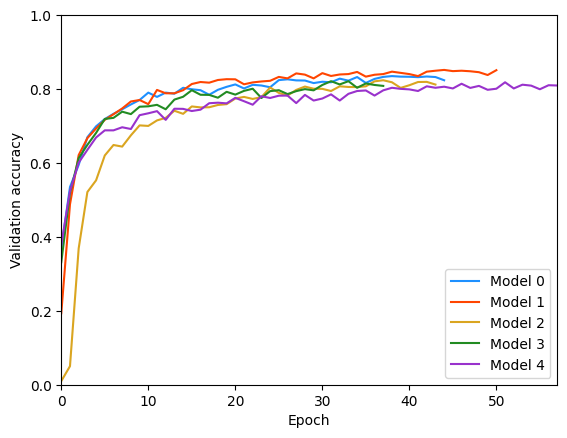

In [7]:
fig, ax = plt.subplots(1,1)
for i in range(5):
    ax.plot(logs[i].epoch, logs[i].val_accuracy, label = f"Model {i}", c = colors[i])

ax.set_xlim(0, max_epochs)
ax.set_ylim(0, 1)
ax.set_ylabel("Validation accuracy")
ax.set_xlabel("Epoch")
ax.legend();

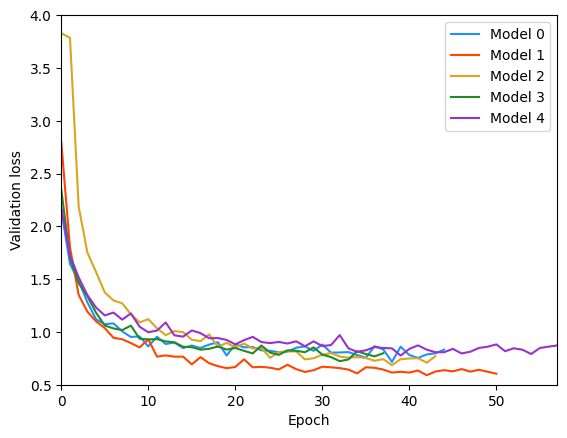

In [8]:
fig, ax = plt.subplots(1,1)
for i in range(5):
    ax.plot(logs[i].epoch, logs[i].val_loss, label = f"Model {i}", c = colors[i])

ax.set_xlim(0, max_epochs)
ax.set_ylim(0.5, 4)
ax.set_ylabel("Validation loss")
ax.set_xlabel("Epoch")
ax.legend();

### Plot example accuracy and loss

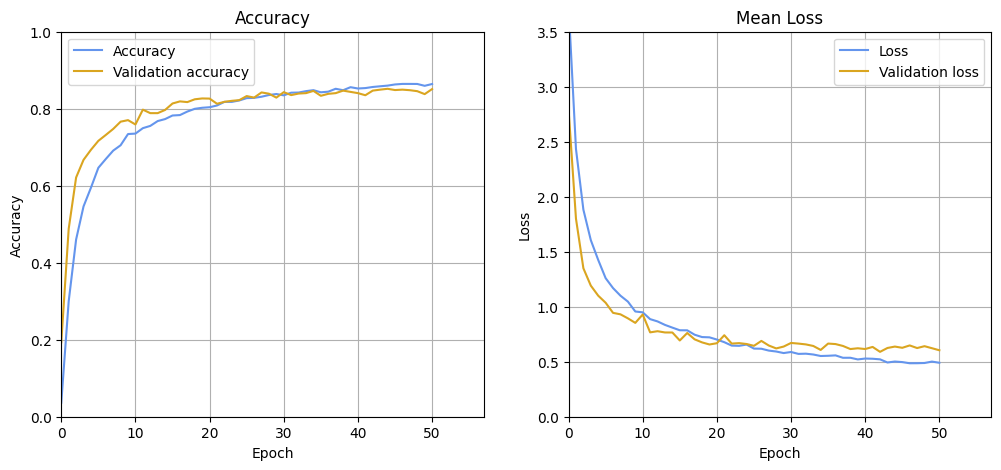

In [9]:
fig, ax = plt.subplots(1,2, figsize = (12,5))
i = 1
ax[0].plot(logs[i].epoch, logs[i].accuracy, label = "Accuracy", c = "cornflowerblue")
ax[0].plot(logs[i].epoch, logs[i].val_accuracy, label = "Validation accuracy", c = "goldenrod")

ax[0].set_xlim(0, max_epochs)
ax[0].set_ylim(0, 1)
ax[0].set_ylabel("Accuracy")
ax[0].set_xlabel("Epoch")
ax[0].grid()
ax[0].set_title("Accuracy")
ax[0].legend();

ax[1].plot(logs[i].epoch, logs[i].loss, label = "Loss", c = "cornflowerblue")
ax[1].plot(logs[i].epoch, logs[i].val_loss, label = "Validation loss", c = "goldenrod")

ax[1].set_xlim(0, max_epochs)
ax[1].set_ylim(0, 3.5)
ax[1].set_ylabel("Loss")
ax[1].set_xlabel("Epoch")
ax[1].grid()
ax[1].set_title("Mean Loss")
ax[1].legend();

### Mean values of acc vs val_acc, loss vs val_loss

In [10]:
mean_acc = np.zeros(shape = (5, max_epochs+1), dtype = float)
mean_val_acc = np.zeros(shape = (5, max_epochs+1), dtype = float)
mean_loss = np.zeros(shape = (5, max_epochs+1), dtype = float)
mean_val_loss = np.zeros(shape = (5, max_epochs+1), dtype = float)
for i in range(5):
    mean_acc[i, :] = logs[i_max_epochs].accuracy
    mean_val_acc[i, :] = logs[i_max_epochs].val_accuracy
    mean_loss[i, :] = logs[i_max_epochs].loss
    mean_val_loss[i, :] = logs[i_max_epochs].val_loss
    mean_acc[i, :max(logs[i].epoch)+1] = logs[i].accuracy
    mean_val_acc[i, :max(logs[i].epoch)+1] = logs[i].val_accuracy
    mean_loss[i, :max(logs[i].epoch)+1] = logs[i].loss
    mean_val_loss[i, :max(logs[i].epoch)+1] = logs[i].val_loss
mean_acc = np.mean(mean_acc, axis = 0)
mean_val_acc = np.mean(mean_val_acc, axis = 0)
mean_loss = np.mean(mean_loss, axis = 0)
mean_val_loss = np.mean(mean_val_loss, axis = 0)

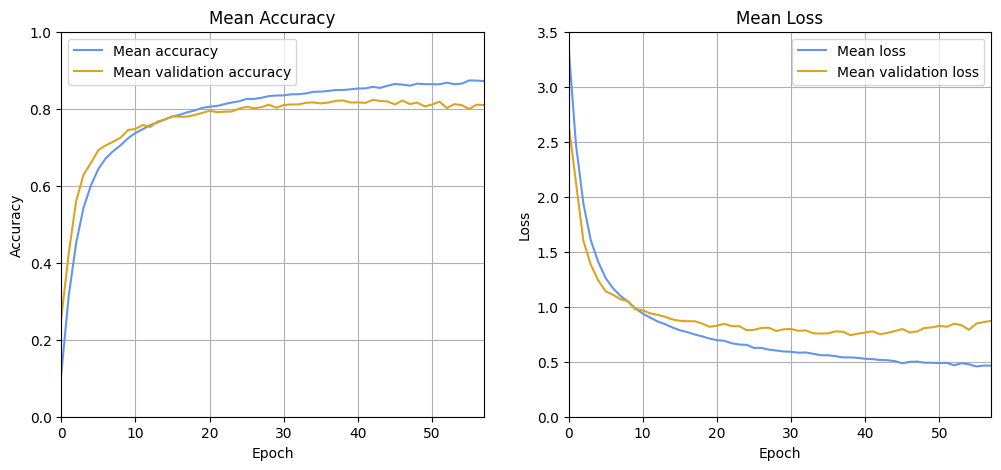

In [11]:
fig, ax = plt.subplots(1,2, figsize = (12,5))
ax[0].plot(range(max_epochs+1), mean_acc, label = "Mean accuracy", c = "cornflowerblue")
ax[0].plot(range(max_epochs+1), mean_val_acc, label = "Mean validation accuracy", c = "goldenrod")

ax[0].set_xlim(0, max_epochs)
ax[0].set_ylim(0, 1)
ax[0].set_ylabel("Accuracy")
ax[0].set_xlabel("Epoch")
ax[0].grid()
ax[0].set_title("Mean Accuracy")
ax[0].legend();

ax[1].plot(range(max_epochs+1), mean_loss, label = "Mean loss", c = "cornflowerblue")
ax[1].plot(range(max_epochs+1), mean_val_loss, label = "Mean validation loss", c = "goldenrod")

ax[1].set_xlim(0, max_epochs)
ax[1].set_ylim(0, 3.5)
ax[1].set_ylabel("Loss")
ax[1].set_xlabel("Epoch")
ax[1].grid()
ax[1].set_title("Mean Loss")
ax[1].legend();

## Make predictions

In [11]:
#preds_train = np.zeros(shape = (len(df_train), cfg.n_classes, 5), dtype = float)
#for i in range(5):
#    for ID in tqdm(range(len(df_train))):
#        preds_train[ID, :, i] = predict_file(df_train, ID, models[i], cfg=cfg)

  0%|                                                                                         | 0/13875 [00:00<?, ?it/s]WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
I0000 00:00:1721832187.198571   10377 service.cc:145] XLA service 0x7f6104002950 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1721832187.198639   10377 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce GTX 1660 SUPER, Compute Capability 7.5
2024-07-24 16:43:07.208878: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-07-24 16:43:07.252999: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
I0000 00:00:1721832188.818412   10377 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
100%|████████████████████████

In [28]:
## Save the array to a .npy file
#np.save('../results/preds_train.npy', preds_train)

# Load the array back from the .npy file
preds_train = np.load('../results/preds_train.npy')

### Use mean for predictions

In [13]:
preds_train_mean = np.mean(preds_train, axis = -1)

In [14]:
preds_class_train = np.argmax(preds_train_mean, axis=1)
one_hot_pred_train = np.zeros_like(preds_train_mean)
one_hot_pred_train[np.arange(len(preds_class_train)), preds_class_train] = 1

true_labels_train = df_train.label

In [15]:
print(f"Accuracy on training data: {accuracy_score(df_train.label, preds_class_train)*100:.4f} %")
print(f"Balanced accuracy score on training data: {balanced_accuracy_score(df_train.label, preds_class_train)*100:.4f} %")

Accuracy on training data: 93.9099 %
Balanced accuracy score on training data: 93.7723 %


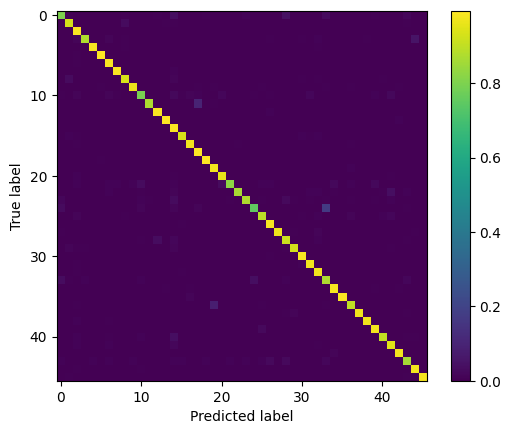

In [16]:
cm = confusion_matrix(df_train.label, preds_class_train, normalize = "true")

plt.imshow(cm, interpolation='nearest', cmap="viridis")
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label');

### Use best estimator for predictions

In [17]:
i_best = 0
acc_best = 0
for i in range(5):
    if max(logs[i].val_accuracy) > acc_best:
        acc_best = max(logs[i].val_accuracy)
        i_best = i
i_best

1

In [18]:
preds_train_best = preds_train[:,:, i_best]

Accuracy on training data: 90.2270 %
Balanced accuracy score on training data: 89.2920 %


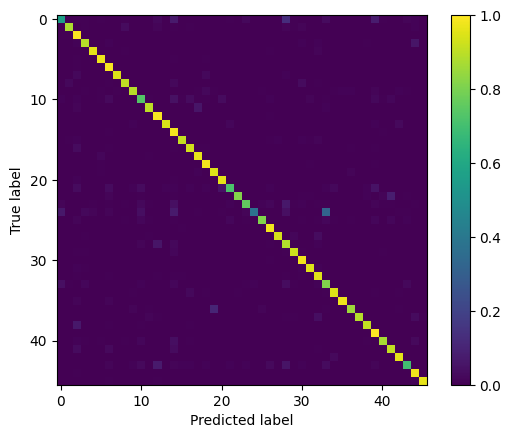

In [19]:
preds_class_train = np.argmax(preds_train_best, axis=1)
print(f"Accuracy on training data: {accuracy_score(df_train.label, preds_class_train)*100:.4f} %")
print(f"Balanced accuracy score on training data: {balanced_accuracy_score(df_train.label, preds_class_train)*100:.4f} %")
cm = confusion_matrix(df_train.label, preds_class_train, normalize = "true")

plt.imshow(cm, interpolation='nearest', cmap="viridis")
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label');

### Use voting

In [20]:
preds_train_vote = np.argmax(preds_train, axis=1)

In [21]:
preds_train_vote

array([[ 2,  2,  2,  2,  2],
       [ 2,  2,  2,  2,  2],
       [ 2,  2,  2, 39,  2],
       ...,
       [13, 13, 13, 13, 13],
       [13, 13, 13, 13, 13],
       [13,  9, 13, 13, 13]])

In [22]:
from scipy.stats import mode
preds_class_train = mode(preds_train_vote, axis = 1).mode

Accuracy on training data: 93.4631 %
Balanced accuracy score on training data: 93.3098 %


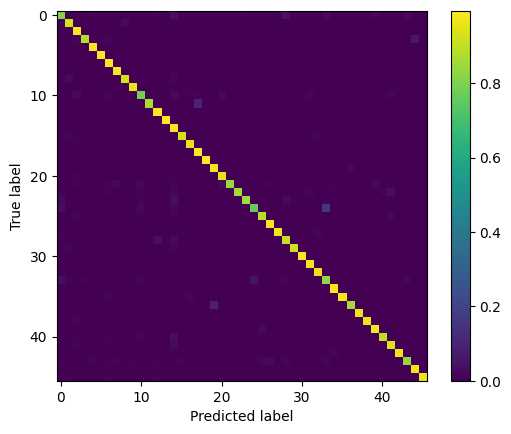

In [23]:
print(f"Accuracy on training data: {accuracy_score(df_train.label, preds_class_train)*100:.4f} %")
print(f"Balanced accuracy score on training data: {balanced_accuracy_score(df_train.label, preds_class_train)*100:.4f} %")
cm = confusion_matrix(df_train.label, preds_class_train, normalize = "true")

plt.imshow(cm, interpolation='nearest', cmap="viridis")
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label');

## Predictions on test data

In [72]:
#preds_test = np.zeros(shape = (len(df_test), cfg.n_classes, 5), dtype = float)
#for i in range(5):
#    for ID in tqdm(range(len(df_test))):
#        preds_test[ID, :, i] = predict_file(df_test, ID, models[i], cfg=cfg)

100%|███████████████████████████████████████████████████████████████████████████████| 3506/3506 [05:31<00:00, 10.59it/s]


In [33]:
# Save the array to a .npy file
#np.save('../results/preds_test.npy', preds_test)

# Load the array back from the .npy file
preds_test = np.load('../results/preds_test.npy')

In [34]:
preds_test_mean = np.mean(preds_test, axis = -1)
preds_class_test = np.argmax(preds_test_mean, axis=1)

Accuracy on test data: 89.3326 %
Balanced accuracy score on test data: 88.1125 %


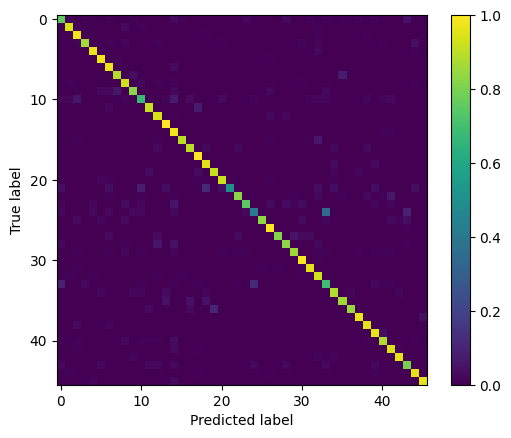

In [139]:
print(f"Accuracy on test data: {accuracy_score(df_test.label, preds_class_test)*100:.4f} %")
print(f"Balanced accuracy score on test data: {balanced_accuracy_score(df_test.label, preds_class_test)*100:.4f} %")
cm_test = confusion_matrix(df_test.label, preds_class_test, normalize = "true")

plt.imshow(cm_test, interpolation='nearest', cmap="viridis")
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label');

In [57]:
trues_test = to_categorical(df_test.label)
trues_train = to_categorical(df_train.label)

In [150]:
def plot_probability_dist(classnr, preds_test, trues_test, preds_train, trues_train):
    fig = plt.figure(figsize = (5, 4))
    _, bins, _ = plt.hist(preds_test[:, classnr][trues_test[:, classnr] == 1], bins = 15, color = "chartreuse", range = [0, 1], 
                      density = True, label = f"Target class, test data", alpha = .8)
    plt.hist(preds_test[:, classnr][trues_test[:, classnr] != 1], bins = bins, color = "fuchsia", 
             density = True, label = f"Other classes, test data", alpha = .6)
    plt.hist(preds_train[:, classnr][trues_train[:, classnr] == 1], bins = bins, color = "forestgreen", range = [0, 1], 
             density = True, label = f"Target class, trainin data", histtype = "step", lw = 2)
    plt.hist(preds_train[:, classnr][trues_train[:, classnr] != 1], bins = bins, color = "slateblue", 
             density = True, lw = 2, label = f"Other classes, training data", histtype = "step")
    plt.xlabel(f"Probability of belonging to class {classnr}")
    plt.ylabel("Counts [a.u.]")
    plt.title(f"Probability distribution for true {classnr}", fontsize = 12)
    plt.legend()
    plt.tight_layout()
    return fig

/tmp/ipykernel_123/3844374125.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize = (5, 4))


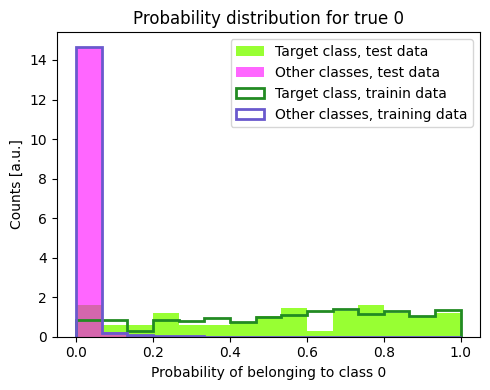

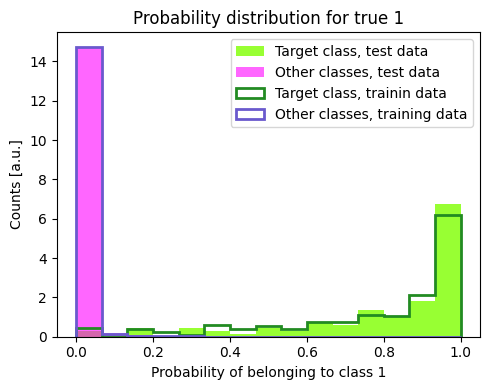

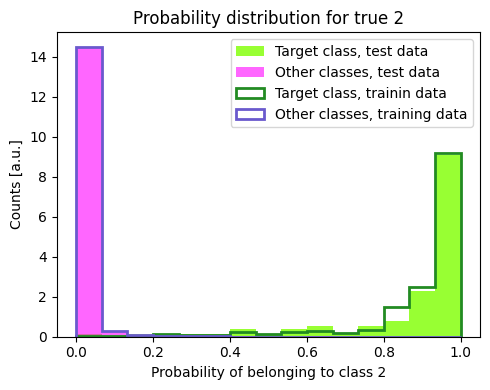

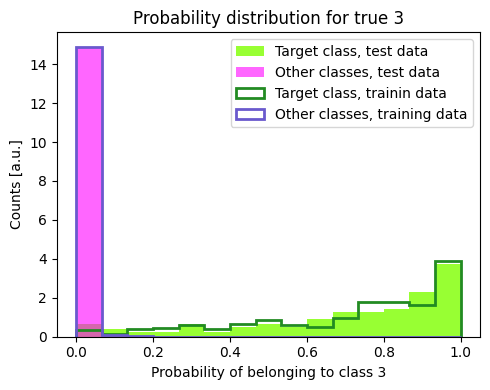

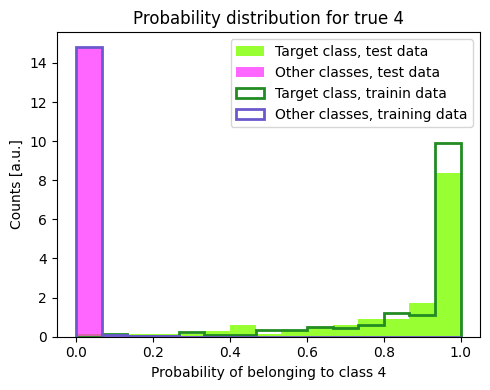

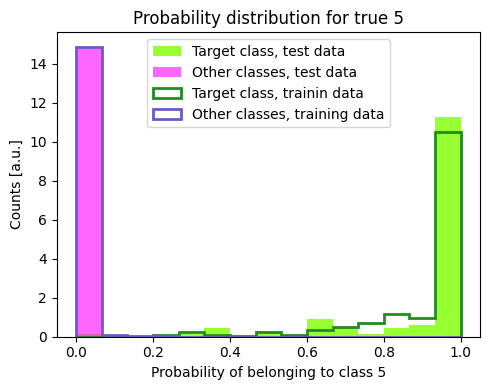

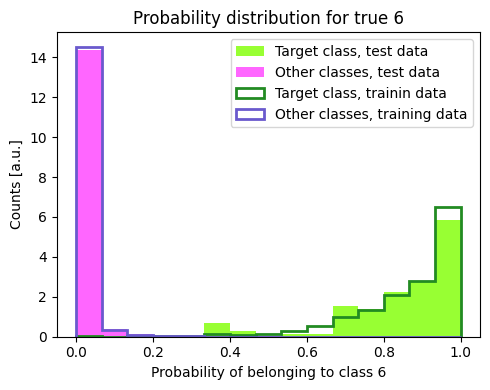

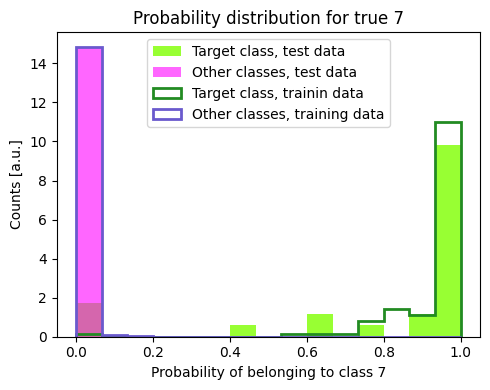

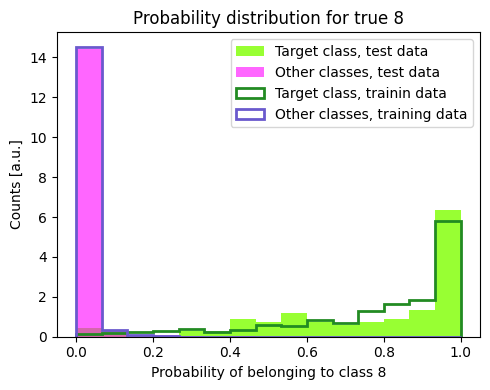

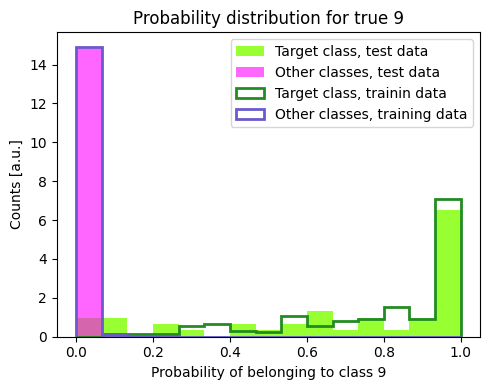

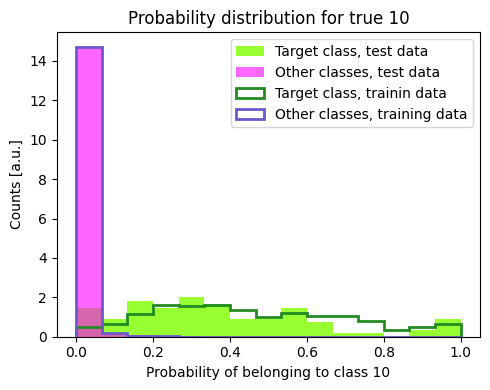

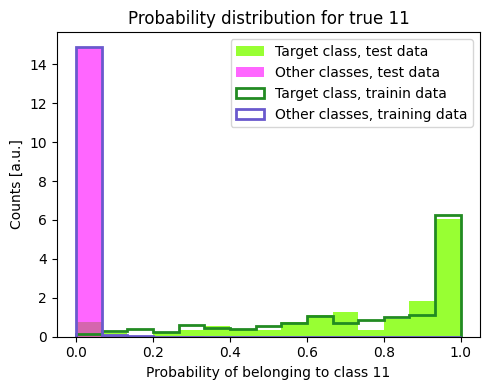

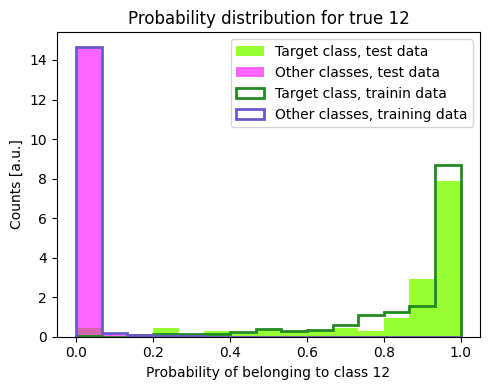

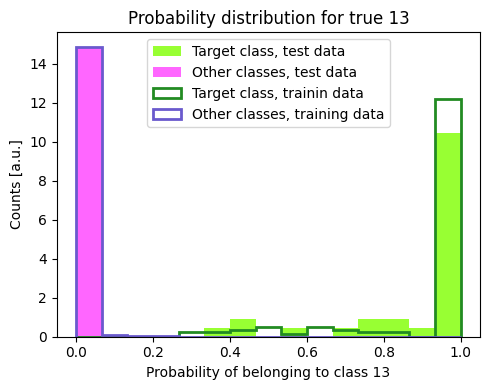

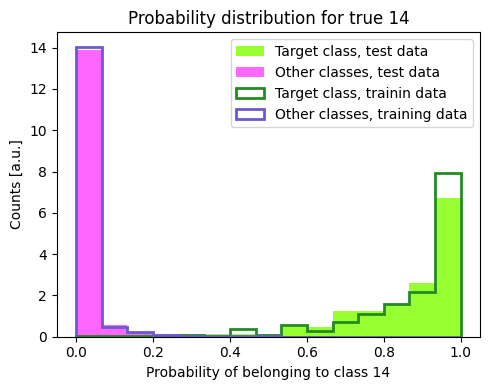

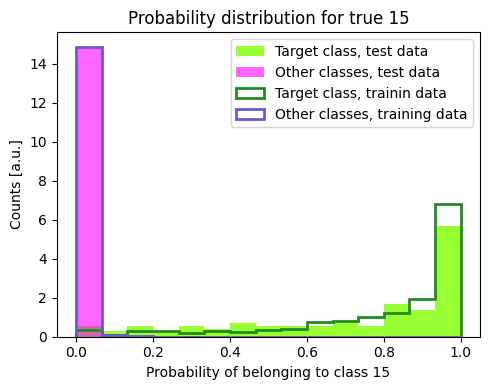

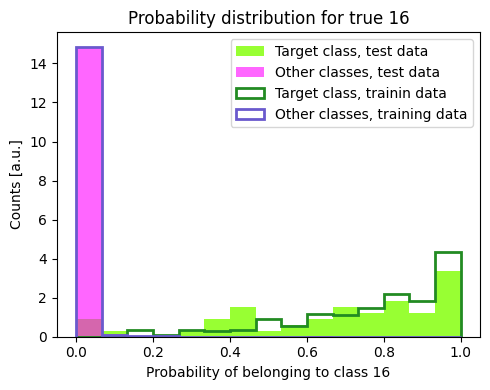

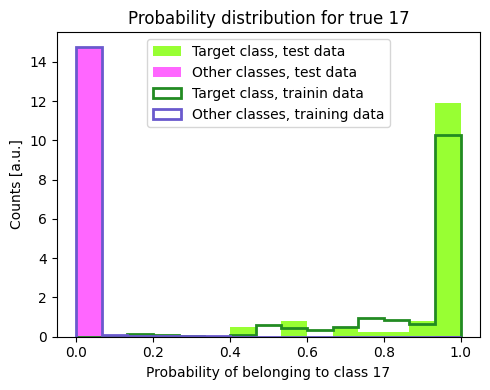

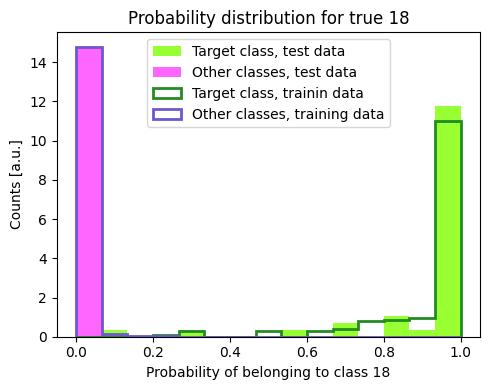

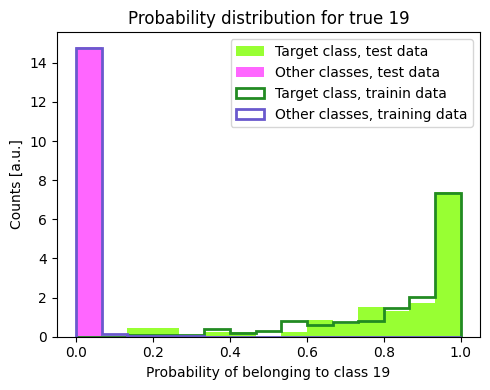

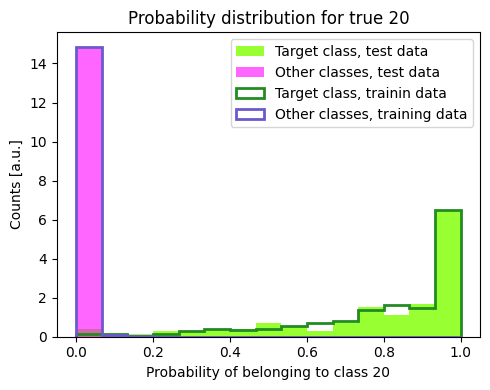

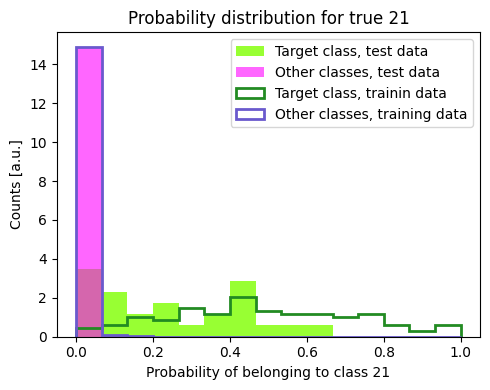

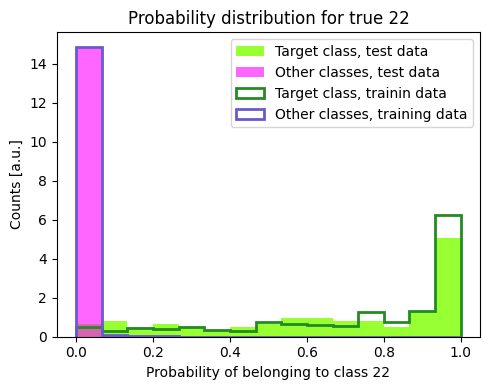

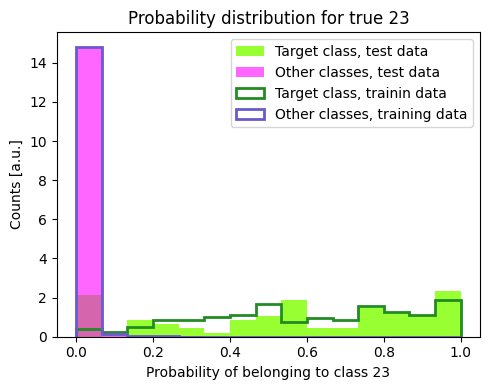

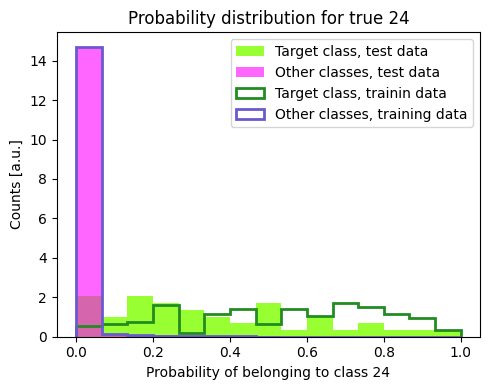

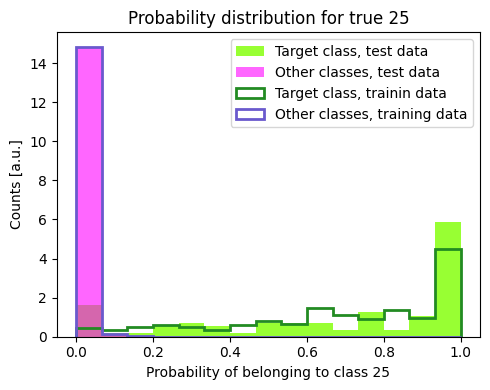

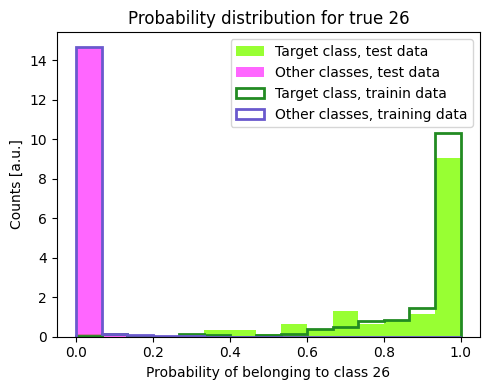

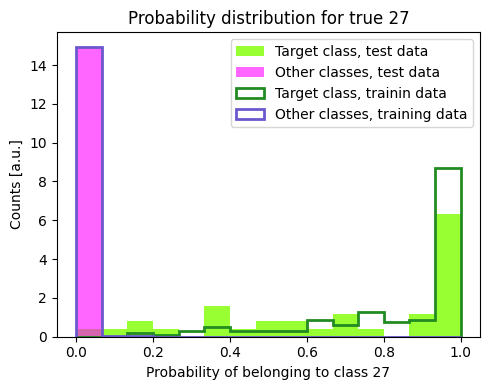

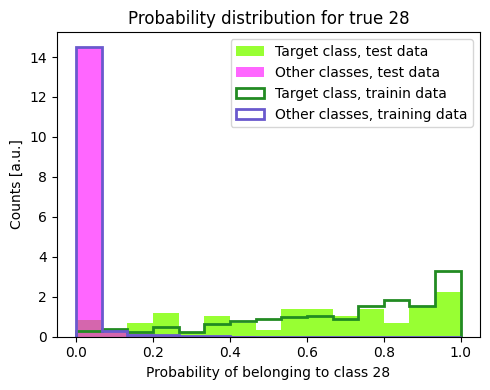

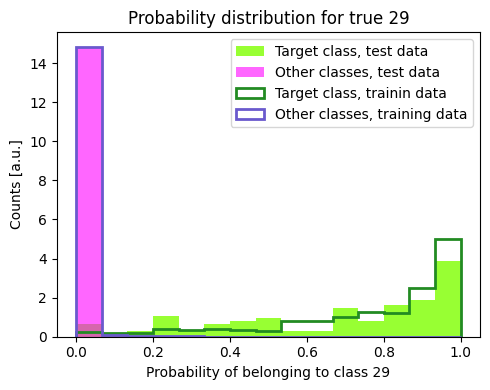

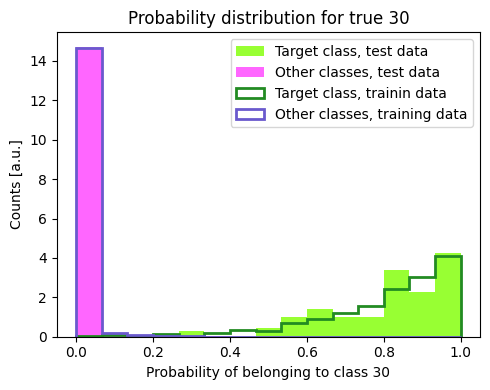

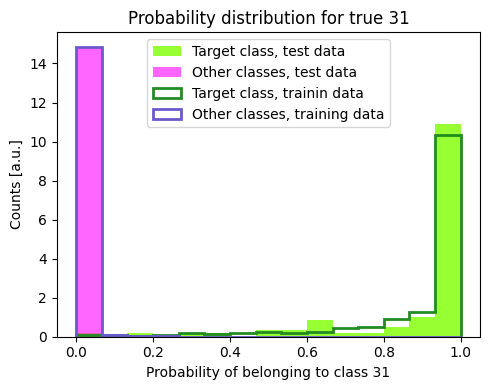

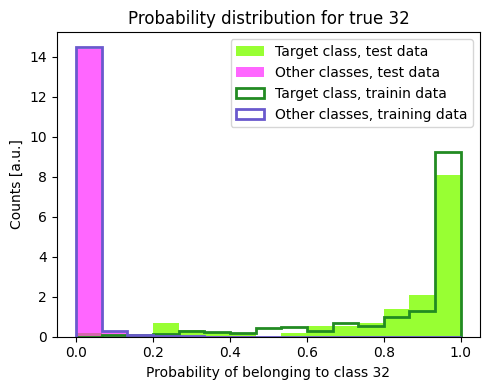

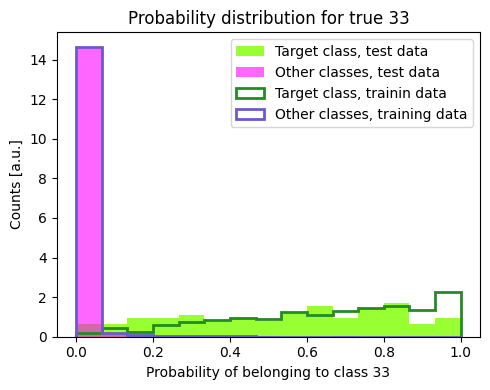

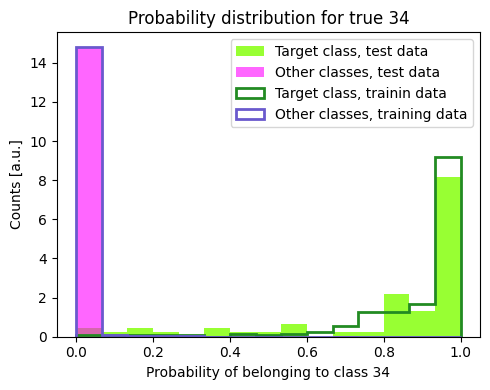

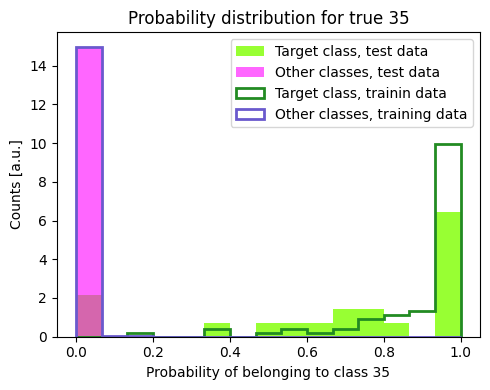

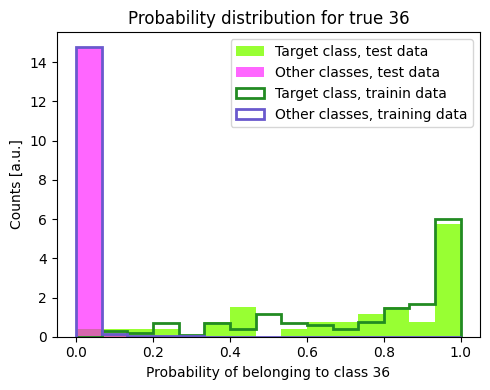

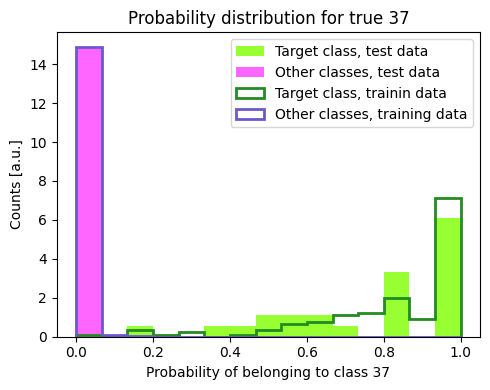

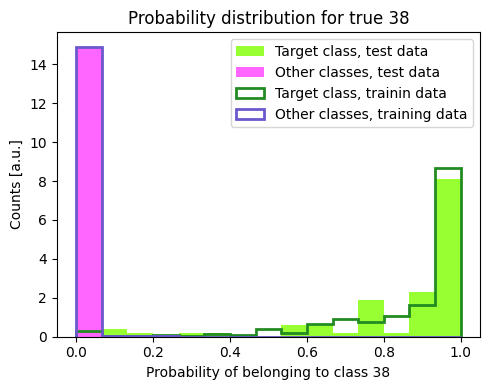

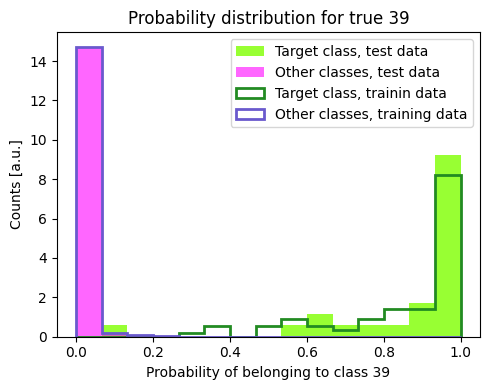

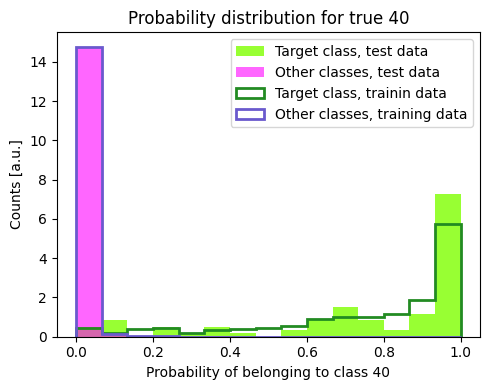

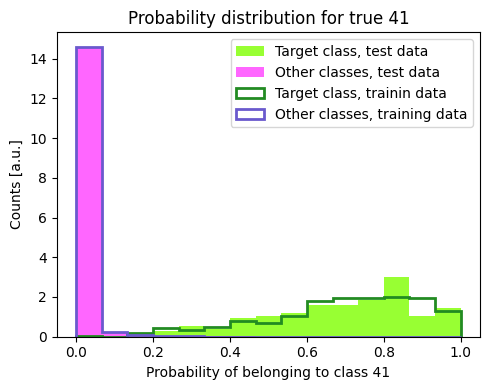

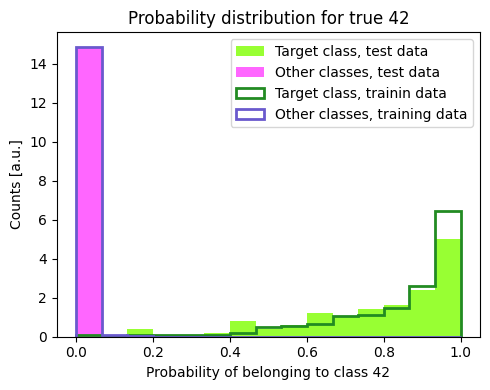

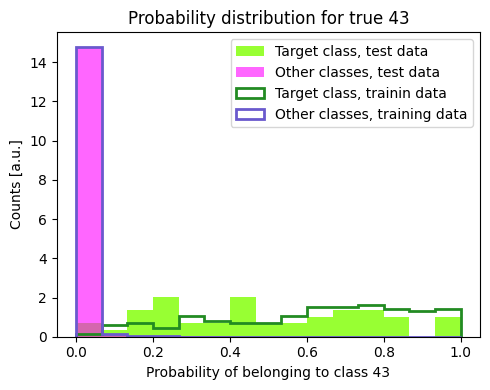

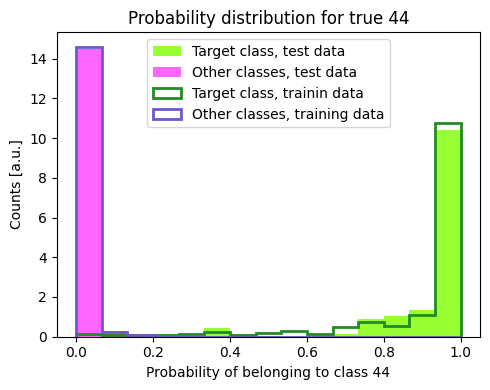

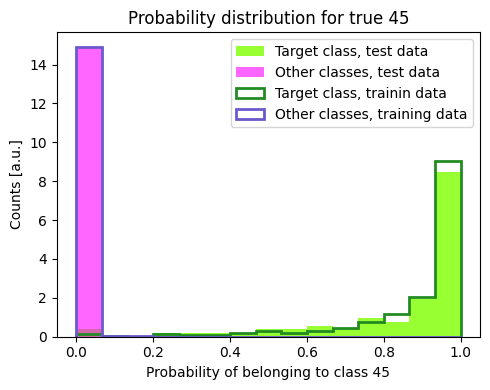

In [151]:
for i in range(46):
    plot_probability_dist(i, preds_test_mean, trues_test, preds_train_mean, trues_train)

## Wrong classifications

In [149]:
worst_classes = np.argsort(np.diag(cm_test))
worst_classes[:10]

array([24, 21, 10, 33, 23,  0, 43, 27,  9, 22])

# ToDo:
    -Plot accuracy vs. average audio length / number of files or smth like that 
    -Plot worst classifications

### Most importantly: Can it identify birds I recorded myself?

In [78]:
from functions import compute_spec, predict_spec
files = ["Vogel_Terasse.mp3", "Terasse1.mp3", "Terasse2.mp3", "Terasse3.mp3"]
for i in range(len(files)):
    files[i] = "../../data/own_recordings/" + files[i]

specs = []
for file in files:
    specs.append(compute_spec(file, cfg = cfg))

preds = np.zeros(shape = (len(files), cfg.n_classes, 5), dtype = float)
for i in range(5):
    for j in range(len(specs)):
        preds[j, :, i] = predict_spec(specs[j], models[i], cfg = cfg)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


In [79]:
preds_mean = np.mean(preds, axis = -1)

In [81]:
np.argmax(preds_mean, axis = 1)

array([ 4, 11, 37, 37])

In [86]:
df_test[df_test.label == 37]["en"]

2346    Meadow Pipit
2347    Meadow Pipit
2348    Meadow Pipit
2349    Meadow Pipit
2350    Meadow Pipit
2351    Meadow Pipit
2352    Meadow Pipit
2353    Meadow Pipit
2354    Meadow Pipit
2355    Meadow Pipit
2356    Meadow Pipit
2357    Meadow Pipit
2358    Meadow Pipit
2359    Meadow Pipit
2360    Meadow Pipit
2361    Meadow Pipit
2362    Meadow Pipit
2363    Meadow Pipit
2364    Meadow Pipit
2365    Meadow Pipit
2366    Meadow Pipit
2367    Meadow Pipit
2368    Meadow Pipit
2369    Meadow Pipit
2370    Meadow Pipit
2371    Meadow Pipit
2372    Meadow Pipit
Name: en, dtype: object